In [28]:
library(RCurl)
library(XML)
library(ggmap)
library(dplyr)
library(lubridate)
library(ggrepel)

### Load Necessary Functions
* **collectNBACalendar**: Function to gather from internet the NBA calendar for a specific year.
* **earth.dist**: Given latitude and longitude for two points calculate the distance between them.
* **nbaFlightsByTeam**: Returns a data frame with flights and the distance for a specific team during the season.

In [2]:
source('NBA season calendar Functions.R')

Warning message:
"package 'xml2' was built under R version 3.3.3"
Attaching package: 'rvest'

The following object is masked from 'package:XML':

    xml



# Overview

NBA have 30 teams playing 82 games each during a regular season

Can we optmize the NBA and provide a better with lower distance travel?

# Data

### Scrapping data from Internet

Collecting the calendar from https://www.basketball-reference.com

In [3]:
calendar<-collectNBACalendar(2016)

In [4]:
head(calendar)

date,time,visitor,visitor_pts,home,home_pts,season
"Fri, Jan 1, 2016",8:00 pm,New York Knicks,81,Chicago Bulls,108,2016
"Fri, Jan 1, 2016",10:30 pm,Philadelphia 76ers,84,Los Angeles Lakers,93,2016
"Fri, Jan 1, 2016",7:30 pm,Dallas Mavericks,82,Miami Heat,106,2016
"Fri, Jan 1, 2016",7:30 pm,Charlotte Hornets,94,Toronto Raptors,104,2016
"Fri, Jan 1, 2016",7:00 pm,Orlando Magic,91,Washington Wizards,103,2016
"Sat, Jan 2, 2016",3:00 pm,Brooklyn Nets,100,Boston Celtics,97,2016


### Transforming Date format

In [5]:
calendar$date2<-unlist(lapply(strsplit(gsub(",","",calendar$date)," "),function(x) paste(x[2:4],collapse = "-")))
calendar$date2<-as.Date(calendar$date2,"%b-%d-%Y")
calendar<-calendar%>%
  arrange(date2)

In [6]:
calendar%>%
    filter(complete.cases(.))%>%
    group_by()%>%
    summarise(min(date2),max(date2))

min(date2),max(date2)
2015-10-27,2016-06-19


### Filter Regular Season Games
For this calendar there are playoffs games and we are not interested on playoffs once we are evaluating the distance traveled during the regular season.

The 2015-16 season ranged from 10-27-2015 to 04-13-2016 (https://en.wikipedia.org/wiki/2015%E2%80%9316_NBA_season)

In [8]:
calendar<-calendar%>%
            filter(date2<='2016-04-13')

In [10]:
# Quick check: Every team must have 82 games
sapply(unique(calendar$home),
       function(x) calendar%>%
  filter((home==x | visitor==x))%>%
  nrow())

Atlanta Hawks          Chicago Bulls  Golden State Warriors 
                    82                     82                     82 
        Boston Celtics          Brooklyn Nets        Detroit Pistons 
                    82                     82                     82 
       Houston Rockets     Los Angeles Lakers      Memphis Grizzlies 
                    82                     82                     82 
            Miami Heat        Milwaukee Bucks  Oklahoma City Thunder 
                    82                     82                     82 
         Orlando Magic           Phoenix Suns Portland Trail Blazers 
                    82                     82                     82 
      Sacramento Kings        Toronto Raptors         Indiana Pacers 
                    82                     82                     82 
  Los Angeles Clippers        New York Knicks    Cleveland Cavaliers 
                    82                     82                     82 
        Denver Nuggets     Philadelphia 76ers      San Antonio Spurs 
                    82                     82                     82 
  New Orleans Pelicans     Washington Wizards      Charlotte Hornets 
                    82                     82                     82 
Minnesota Timberwolves       Dallas Mavericks              Utah Jazz 
                    82                     82                     82

### Define Location of Games

In [11]:
calendar$home_location<-unlist(lapply(strsplit(calendar$home," "),function(x) paste(x[1:(length(x)-1)],collapse=" ")))
calendar$visitor_location<-unlist(lapply(strsplit(calendar$visitor," "),function(x) paste(x[1:(length(x)-1)],collapse=" ")))

In [12]:
unique(calendar$home_location)

[1] "Atlanta"        "Chicago"        "Golden State"   "Boston"        
 [5] "Brooklyn"       "Detroit"        "Houston"        "Los Angeles"   
 [9] "Memphis"        "Miami"          "Milwaukee"      "Oklahoma City" 
[13] "Orlando"        "Phoenix"        "Portland Trail" "Sacramento"    
[17] "Toronto"        "Indiana"        "New York"       "Cleveland"     
[21] "Denver"         "Philadelphia"   "San Antonio"    "New Orleans"   
[25] "Washington"     "Charlotte"      "Minnesota"      "Dallas"        
[29] "Utah"

Based on the name of the home team we can identify the game location. For example, when the home team is 'Chicago Bulls' we know the game was hosted in Chicago.

In a simple example, for a match between 'Chicago Bulls' and 'Memphis Grizzles' where the home team is 'Chicago Bulls' we assume that there was travel from Memphis to Chicago.

Even though the home_location was able to identify the location of games we still had to do some manual adjustments. For example, Golden State -> San Franciso

In [13]:
calendar$home_location[calendar$home_location=="Portland Trail"]<-"Portland"
calendar$home_location[calendar$home_location=="Utah"]<-"Salt Lake City"
calendar$home_location[calendar$home_location=="Indiana"]<-"Indianapolis"
calendar$home_location[calendar$home_location=="Minnesota"]<-"Minneapolis"
calendar$home_location[calendar$home_location=="Golden State"]<-"San Francisco"
calendar$home_location[calendar$home_location=="Washington"]<-"Washington D.C."

### Latitude and Longitude for the Cities where the Teams are located

In [14]:
cities<-unique(calendar$home_location)
pos<-geocode(cities)
citiesLocation<-data.frame(cities,pos)

Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Atlanta&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Chicago&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=San%20Francisco&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Boston&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Brooklyn&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Detroit&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Houston&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Los%20Angeles&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=Memphis&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?addre

In [15]:
head(citiesLocation)

cities,lon,lat
Atlanta,-84.38798,33.74900
Chicago,-87.62980,41.87811
San Francisco,-122.41942,37.77493
Boston,-71.05888,42.36008
Brooklyn,-73.94416,40.67818
Detroit,-83.04575,42.33143


### Calculate the Distance between Teams based on Latitude and Longitude

Create 'distance' data frame that contains every  possible combination between two teams.

In [16]:
distance<-expand.grid(unique(calendar$home_location),unique(calendar$home_location))
names(distance)<-c("team1","team2")

distance<-merge(x=distance,
                y=citiesLocation,
                by.x="team1",
                by.y="cities",
                all.x=TRUE)
names(distance)[3:4]<-c("lon1","lat1")

distance<-merge(x=distance,
                y=citiesLocation,
                by.x="team2",
                by.y="cities",
                all.x=TRUE)
names(distance)[5:6]<-c("lon2","lat2")

In [18]:
head(distance)

team2,team1,lon1,lat1,lon2,lat2
Atlanta,Atlanta,-84.38798,33.74900,-84.38798,33.749
Atlanta,New York,-74.00594,40.71278,-84.38798,33.749
Atlanta,Phoenix,-112.07404,33.44838,-84.38798,33.749
Atlanta,Denver,-104.99025,39.73924,-84.38798,33.749
Atlanta,San Antonio,-98.49363,29.42412,-84.38798,33.749
Atlanta,Milwaukee,-87.90647,43.03890,-84.38798,33.749


Calculate distance between two cities

In [19]:
distance$distanceKM<-apply(distance[,names(distance)%in%c('lon1','lat1','lon2','lat2')],1,function(x) earth.dist(x[1],x[2],x[3],x[4],R=6378.145))

In [17]:
head(distance)

team2,team1,lon1,lat1,lon2,lat2,distanceKM
Atlanta,Atlanta,-84.38798,33.74900,-84.38798,33.749,0.000
Atlanta,New York,-74.00594,40.71278,-84.38798,33.749,1201.665
Atlanta,Phoenix,-112.07404,33.44838,-84.38798,33.749,2559.549
Atlanta,Denver,-104.99025,39.73924,-84.38798,33.749,1949.539
Atlanta,San Antonio,-98.49363,29.42412,-84.38798,33.749,1420.095
Atlanta,Milwaukee,-87.90647,43.03890,-84.38798,33.749,1078.468


### Function to calculate Distance traveled by a Team during the season

The nbaFlightsByTeam function returns a data frame with flights and the distance for a specific team during the season.

In [20]:
PHI_flights<-nbaFlightsByTeam(calendar,"Philadelphia 76ers",date=TRUE)

In [36]:
head(PHI_flights)

flight_from,flight_to,distance
Philadelphia,Boston,436.1181
Boston,Philadelphia,436.1181
Philadelphia,Philadelphia,0.0000
Philadelphia,Milwaukee,1115.2003
Milwaukee,Cleveland,539.5069
Cleveland,Philadelphia,576.9254


Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=united+states&zoom=4&size=640x640&scale=2&maptype=terrain&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=united%20states&sensor=false
Warning message:
"`panel.margin` is deprecated. Please use `panel.spacing` property instead"

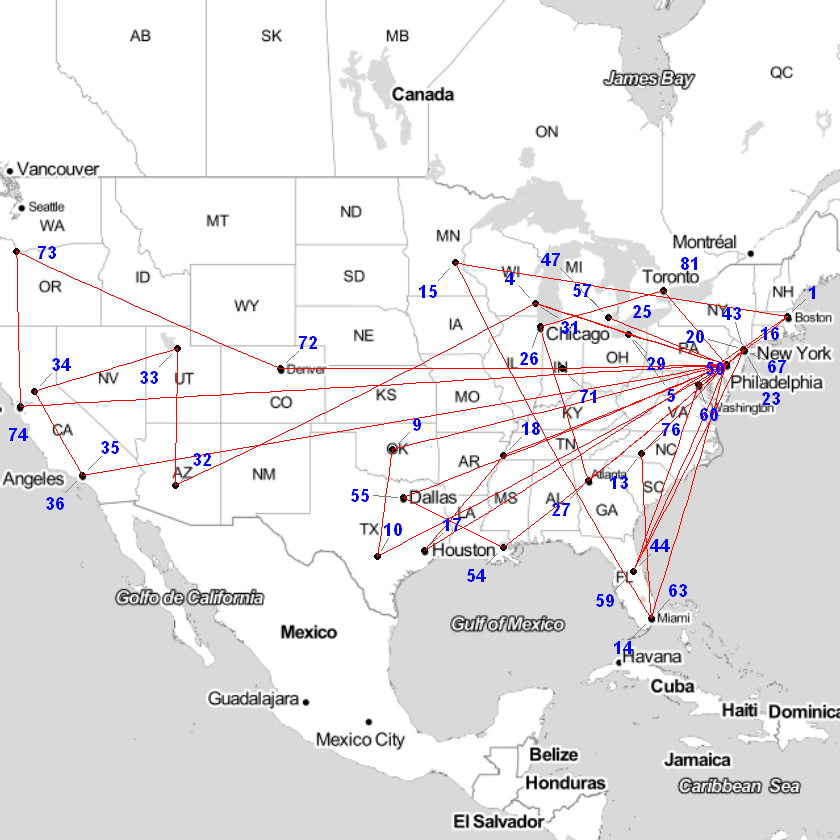

In [35]:
phiFligths<-nbaFlightsByTeam(calendar,"Philadelphia 76ers",date=FALSE)%>%
  mutate(order=1:82)%>%
  merge(y=citiesLocation,
        by.x=c("flight_to"),
        by.y=c("cities"),
        all.x=TRUE)%>%
  rename(lon_to=lon,lat_to=lat)%>%
  merge(y=citiesLocation,
        by.x=c("flight_from"),
        by.y=c("cities"),
        all.x=TRUE)%>%
  rename(lon_from=lon,lat_from=lat)%>%
  arrange(order)

qmap("united states", zoom = 4,maptype = "toner-lite", source = "stamen") +
  geom_point(data=phiFligths,aes(x = lon_to, y = lat_to))+
  geom_path(aes(x = lon_to, y = lat_to), size = .1, data = phiFligths, colour="red", lineend = "round")+
  geom_text_repel(data = phiFligths%>%filter(flight_to!="Philadelphia") ,aes(x = lon_to, y = lat_to, label = order),
                  fontface = 'bold', color = 'blue',
                  box.padding = unit(0.35, "lines"),
                  point.padding = unit(0.5, "lines"),
                  segment.color = 'grey50')

Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=united+states&zoom=4&size=640x640&scale=2&maptype=terrain&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=united%20states&sensor=false
Warning message:
"`panel.margin` is deprecated. Please use `panel.spacing` property instead"Warning message:
"The plyr::rename operation has created duplicates for the following name(s): (`size`)"

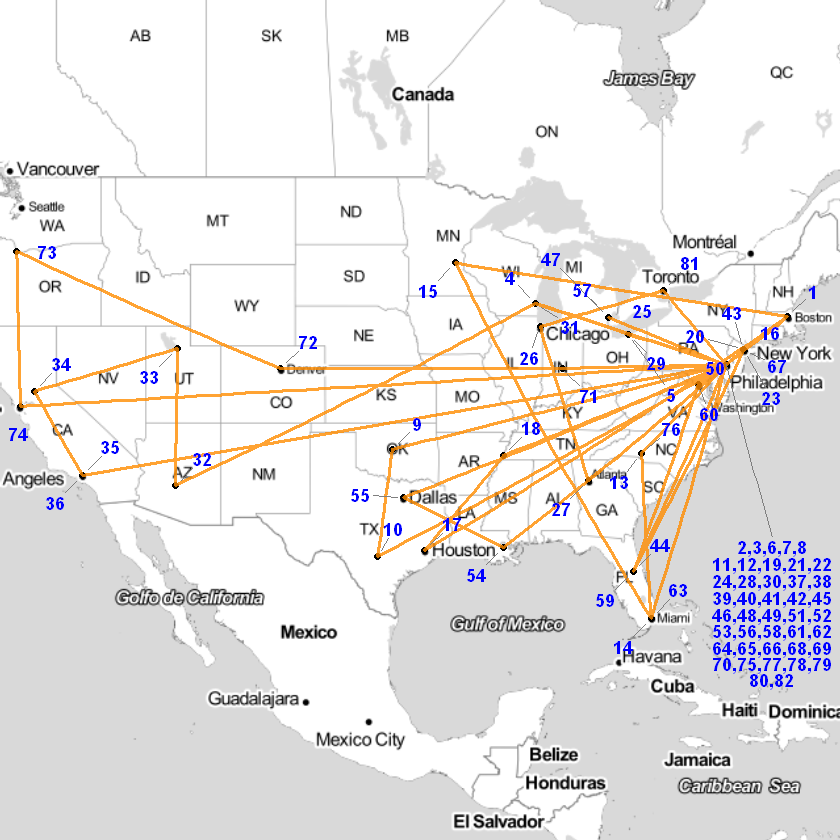

In [44]:
qmap("united states", zoom = 4,maptype = "toner-lite", source = "stamen") +
  geom_point(data=phiFligths,aes(x = lon_to, y = lat_to))+
  geom_path(aes(x = lon_to, y = lat_to), size = 1, data = phiFligths, size=0.1, alpha = 0.8, color = "dark orange", lineend = "round")+
  geom_text_repel(data = phiFligths%>%filter(flight_to!="Philadelphia") ,aes(x = lon_to, y = lat_to, label = order),
                  fontface = 'bold', color = 'blue',
                  box.padding = unit(0.35, "lines"),
                  point.padding = unit(0.5, "lines"),
                  segment.color = 'grey50')+
  annotate("text",x=-72.07,y=30,label=paste(phiFligths[phiFligths$flight_to=="Philadelphia","order"][1:5],collapse=","),color="blue",fontface='bold')+
  annotate("text",x=-72.07,y=29,label=paste(phiFligths[phiFligths$flight_to=="Philadelphia","order"][6:10],collapse=","),color="blue",fontface='bold')+
  annotate("text",x=-72.07,y=28,label=paste(phiFligths[phiFligths$flight_to=="Philadelphia","order"][11:15],collapse=","),color="blue",fontface='bold')+
  annotate("text",x=-72.07,y=27,label=paste(phiFligths[phiFligths$flight_to=="Philadelphia","order"][16:20],collapse=","),color="blue",fontface='bold')+
  annotate("text",x=-72.07,y=26,label=paste(phiFligths[phiFligths$flight_to=="Philadelphia","order"][21:25],collapse=","),color="blue",fontface='bold')+
  annotate("text",x=-72.07,y=25,label=paste(phiFligths[phiFligths$flight_to=="Philadelphia","order"][26:30],collapse=","),color="blue",fontface='bold')+
  annotate("text",x=-72.07,y=24,label=paste(phiFligths[phiFligths$flight_to=="Philadelphia","order"][31:35],collapse=","),color="blue",fontface='bold')+
  annotate("text",x=-72.07,y=23,label=paste(phiFligths[phiFligths$flight_to=="Philadelphia","order"][36:40],collapse=","),color="blue",fontface='bold')+
  annotate("text",x=-72.07,y=22,label=paste(phiFligths[phiFligths$flight_to=="Philadelphia","order"][41:42],collapse=","),color="blue",fontface='bold')+
  geom_segment(x = -72.07, y = 30.5, xend = citiesLocation$lon[citiesLocation$cities=="Philadelphia"], yend = citiesLocation$lat[citiesLocation$cities=="Philadelphia"], colour = "grey50")


To get the total kilometers traveled by the Philadelphia 76ers during the 2015-16 regular season we just have to sum the variable distance.

In [22]:
sum(PHI_flights$distance)

[1] 62334.61

Total distance traveled by team during 2015-16 season

In [23]:
teams<-unique(calendar$home)
total_distance_by_team<-sapply(teams,function(x) sum(nbaFlightsByTeam(calendar,x)$distance))

In [74]:
total_distance_by_team<-as.data.frame(total_distance_by_team[order(total_distance_by_team,decreasing=TRUE)])
total_distance_by_team$team<-rownames(total_distance_by_team)
rownames(total_distance_by_team)<-NULL
colnames(total_distance_by_team)<-c('distance','team')
total_distance_by_team<-total_distance_by_team[c(2,1)]

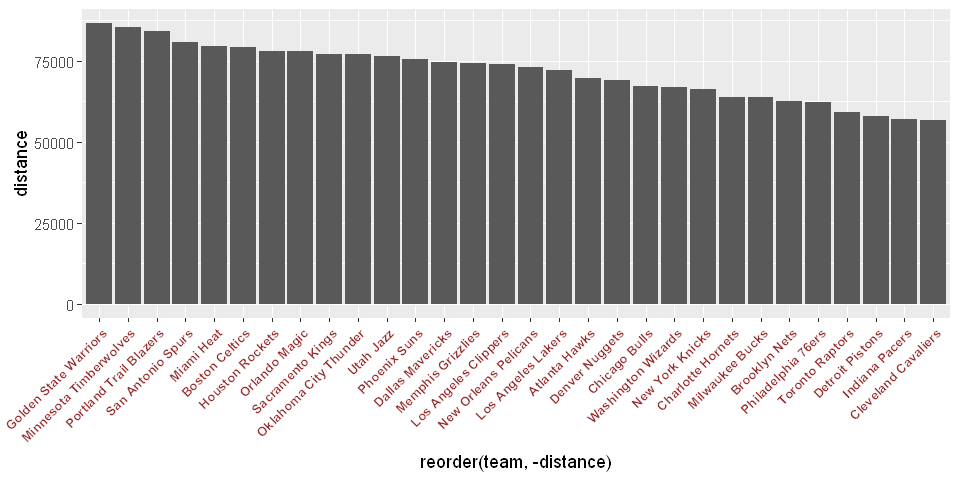

In [100]:
options(repr.plot.width=8, repr.plot.height=4)
ggplot(total_distance_by_team,aes(x=reorder(team,-distance),distance))+
geom_bar(stat = "identity")+
 theme(axis.text.x = element_text(face="bold", color="#993333", 
                           size=8, angle=45, hjust=1))

In [101]:
sum(total_distance_by_team$distance)

[1] 2149348

### Map

### Optmize

Create an new possible calendar:
* Shuffle the calandar

In [103]:
c1 <- calendar[sample(nrow(calendar),replace=FALSE),]

The first 10 games for Philadelphia 76ers using this new calendar would be:

In [104]:
c1%>%
select(home,visitor)%>%
filter(home=="Philadelphia 76ers" | visitor=="Philadelphia 76ers")%>%
head()

home,visitor
New York Knicks,Philadelphia 76ers
Philadelphia 76ers,Orlando Magic
Los Angeles Lakers,Philadelphia 76ers
Golden State Warriors,Philadelphia 76ers
Philadelphia 76ers,Minnesota Timberwolves
Philadelphia 76ers,Toronto Raptors


The first game would be in Brooklyn then the next 4 games would be at home and the sixth game would be in Boston.

Very different from the real calendar. The distance traveled increased.

In [105]:
cat("Original Calendar:\t",
    sum(nbaFlightsByTeam(calendar,"Philadelphia 76ers",date=FALSE)$distance),
    "\nCandidate Calendar:\t",sum(nbaFlightsByTeam(c1,"Philadelphia 76ers",date=FALSE)$distance))

Original Calendar:	 62334.61 
Candidate Calendar:	 88506.35

Total distance traveled also increased.

In [106]:
cat("Original Calendar:\t",
    sum(sapply(teams,function(x) sum(nbaFlightsByTeam(calendar,x,date=FALSE)$distance))),
        "\nCandidate Calendar:\t",
        sum(sapply(teams,function(x) sum(nbaFlightsByTeam(c1,x,date=FALSE)$distance))))

Original Calendar:	 2149348 
Candidate Calendar:	 3136225

### Would be able to create a new calendar with low distance traveled.

As I wrote in the begining of the post I believe it is hard to improve the original NBA calendar, but still we can try to create a new calendar with a resonable solution.

In [123]:
result<-rep(NA,1000)
for(i in 1:length(result)){
    c_<-calendar[sample(nrow(calendar),replace=FALSE),]
    result[i]<-sum(sapply(teams,function(x) sum(nbaFlightsByTeam(c_,x,date=FALSE)$distance)))
}

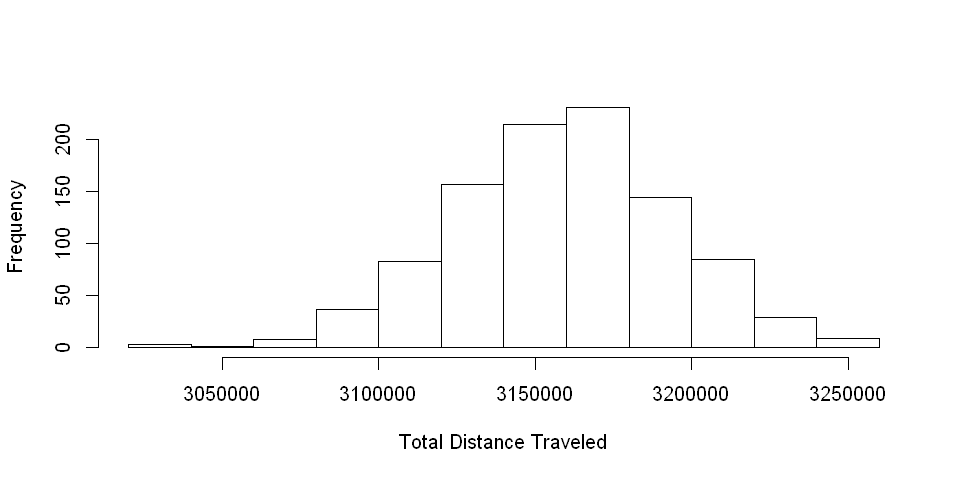

In [130]:

hist(result,main="",xlab="Total Distance Traveled")

As you can see, find the calendar with a low distance traveled is not an easy task. We randomly generated 1,000 calendar and the minimum result was not even close to the original calendar

In [126]:
min(result)

[1] 3023599